# Library

In [1]:
import numpy as np

from DataPreProcessing import dataOrdering, padding, lagging, dataSplitting, SpiralDataset_2inputs, dataSplitting, processData
from SindyShredModel import SINDySHRED, fit_SindyShred_param
from TestSindyShred import test_error, plot_sensors_comparison_shred, plot_sensors_comparison_sindy, plot_shred_comparison_1D, plot_shred_comparison_2D

# Load the Data

The data must be of shape (nx, nt, nf, num_param) or (nx, ny, nt, nf, num_param) or (nx, ny, nz, nt, nf, num_param)

-nx, ny, nz are the spatial dimensions

-nt is the lenght of the temporal sequence

-nf is the number of features

-num_param is the number of parameters used. To be clearer: if num_param = 1, it means there is only one system generated by such 
parameter. If num_param is 10, it means you have 10 systems each one generated by its param.

In [2]:
data = np.load('uv_multi_param_100_n_50_L_20.npy')
data = data[:,:,:100,:,:]
nx, ny, nt, nf, num_param = data.shape
spatial_dim = nx*ny
dt = 0.05
#load the param beta_array
beta_array = np.linspace(0.1, 10, num_param)
print("data shape: ", data.shape)

data shape:  (50, 50, 100, 2, 100)


# Data Processing

Decide if you want to apply noise or not

In [ ]:
# NO added noise
noise = None

In [ ]:
# Add noise
noise = 0.1 * np.max(data)

Decide if you want to train with respect to parameters or time

In [ ]:
# Train w.r.t parameters
param_split = True

In [ ]:
# Train w.r.t time
param_split = False

Process the data

In [64]:
lag = 11
num_sensors = 40
train_ratio = 0.8
val_ratio = 0.1
data_train, data_val, data_test = processData(data=data, parameters=beta_array, 
                                              lags=lag, num_sensors=num_sensors, 
                                              train_ratio=train_ratio, val_ratio=val_ratio,
                                              param_split = param_split,
                                              constant_params=True, noise=noise)

n_states:  5000
data ordered
data padded
data lagged
lagged_data_sens shape:  (10000, 11, 40)
data split


# Define the Model

In [5]:
hidden_size = 3
hidden_layers = 2
n_states = spatial_dim * nf
def create_z_labels(hidden_size):
    return [f"z{i+1}" for i in range(hidden_size)]
features_names = create_z_labels(hidden_size)
params_names = ['beta']
model = SINDySHRED(max_degree=1, features_name=features_names, dt=dt, param_names=params_names,
                   threshold=3*1e-1,
                   num_sensors=num_sensors, num_param=num_param, n_states = n_states,
                   hidden_layers=hidden_layers, hidden_size=hidden_size,
                   decoder_sizes=[40, 400], dropout=0.15)

# Train the Model

In [66]:
batch_size = 25

if param_split:
    assert nt % batch_size == 0, 'batch_size must divide nt'
else:
    assert int(nt*train_ratio) % batch_size == 0, 'batch_size must divide nt*train_ratio'

num_epochs = 1000
lambda_sindy = 1e-1

valid_error_list, train_error_list = fit_SindyShred_param(model, data_train, data_val, batch_size,
                                                          num_epochs, 1e-2, lambda_sindy, verbose=True, patience=8)

Training epoch 1
Training error: 0.07235759496688843
Validation error: 0.06456492841243744
z1' = -0.49*z2 + -0.33*beta*z2 + -0.74*beta*z3
z2' = 0.46*z1 + 0.39*z3 + 0.45*beta*z1 + -0.35*beta*z2 + -0.45*beta*z3
z3' = -0.43*z1 + 0.58*beta*z1 + 0.51*beta*z2
Training epoch 2
Training error: 0.08173885196447372
Validation error: 0.07180770486593246
Training epoch 3
Training error: 0.08012423664331436
Validation error: 0.06884497404098511
Training epoch 4
Training error: 0.07183291763067245
Validation error: 0.06607932597398758
Training epoch 5
Training error: 0.08117587864398956
Validation error: 0.07143662124872208
Training epoch 6
Training error: 0.06840802729129791
Validation error: 0.06013869494199753
Training epoch 7
Training error: 0.0711212009191513
Validation error: 0.06183109059929848
Training epoch 8
Training error: 0.07492826879024506
Validation error: 0.0651342123746872
Training epoch 9
Training error: 0.08095818758010864
Validation error: 0.06950429081916809
Training epoch 10
Tr

# Test and Plot

error computation, divided into shred and sindy errors

In [67]:
error_shred, error_sindy = test_error(model, data_test)
print("SHRED error: ", error_shred)
print("SINDy error: ", error_sindy)

SHRED error:  tensor(0.0576)
SINDy error:  tensor(0.0009)


SELECT the paramter and the test temporal range

In [68]:
if param_split:
    k = np.random.randint(0, int(num_param*(1-train_ratio-val_ratio)))
    test_range = nt
else:
    k = np.random.randint(0, num_param)
    test_range = int(nt*(1-train_ratio-val_ratio))

Plot a comparison between the real values in 3 random point across time, for a random parameter sampled from the test set

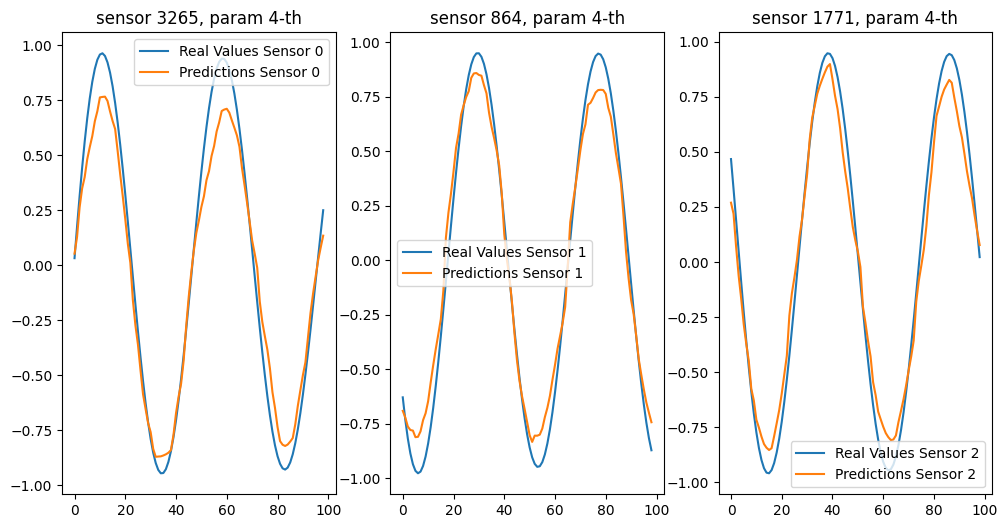

In [69]:
plot_sensors_comparison_shred(model, data_test, test_range, k)

Plot the hidden dimensions and the sindy predictions over time

z1' = 1.14*z2 + -0.76*z3 + -0.54*beta*z3
z2' = 0.53*z1 + 0.41*z3 + -0.65*beta*z3
z3' = -0.30*z1 + 0.86*z2 + -0.48*z3 + 0.38*beta*z1 + 0.90*beta*z2


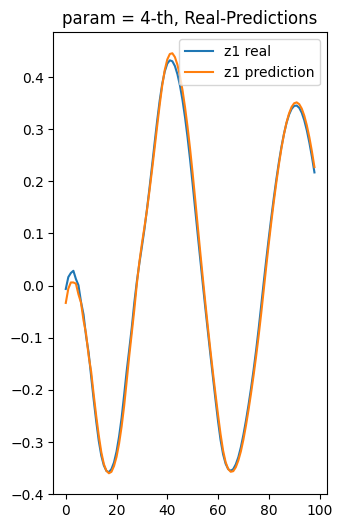

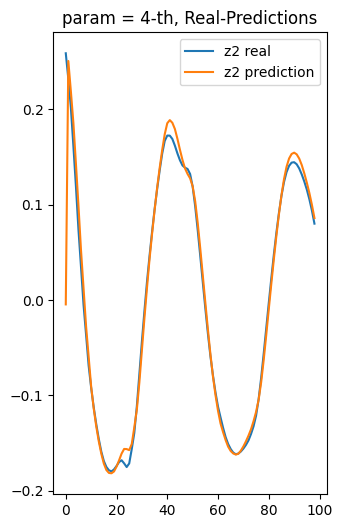

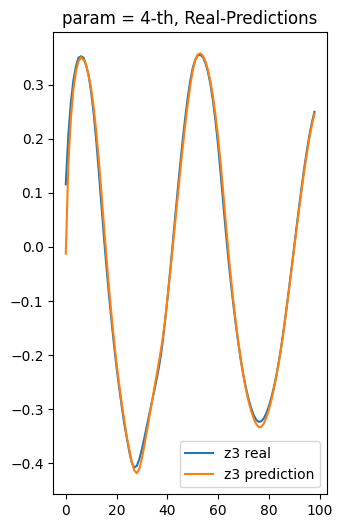

In [70]:
plot_sensors_comparison_sindy(model, data_test, test_range, k)

Plot the final prediction of the system. Visualize every feature at a random instant, for a random parameter from the test set

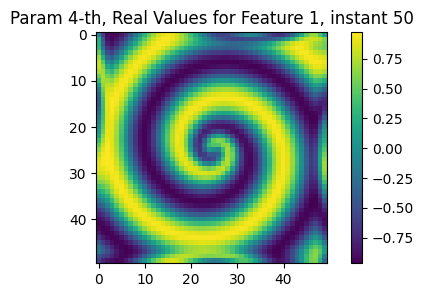

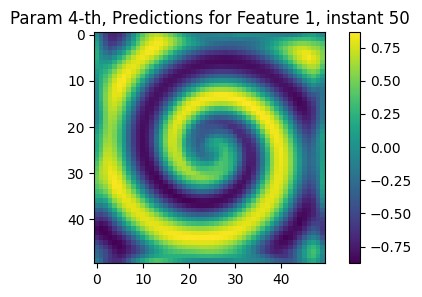

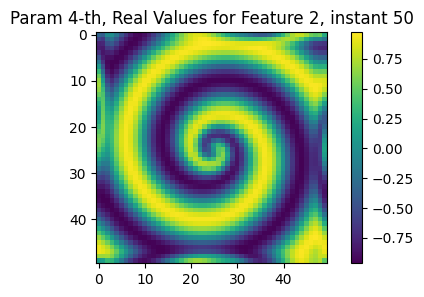

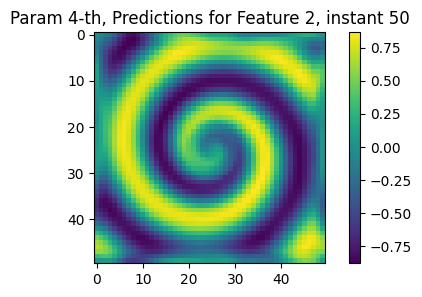

In [74]:
instant = np.random.randint(0,test_range)
if param_split:
    plot_shred_comparison_2D(model, data_test, instant, nx, ny, test_range, nf, k)
else:
    plot_shred_comparison_2D(model, data_test, instant, nx, ny, test_range+1, nf, k)

Smoothening effect of the GRU module

In [78]:
noise = 1

gru_smooth shape:  (1000, 3)


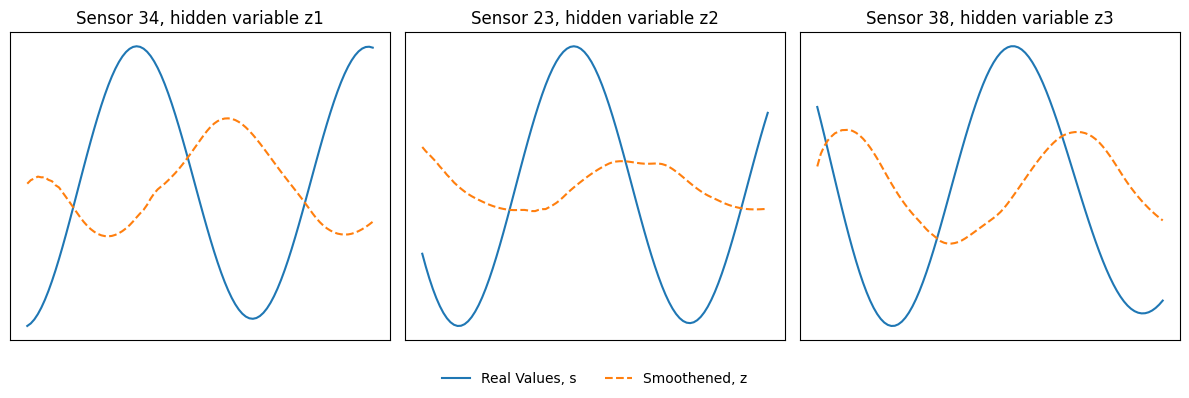

In [88]:
import matplotlib.pyplot as plt
if noise is not None:
    sensor_locations = np.random.randint(0, num_sensors, 3)

    real_values = data_test.data.X[:,-1,:].detach().cpu().numpy()
    gru_smooth = model.gru(data_test.data.X[:,1:,:]).detach().cpu().numpy()
    sensor_locations = np.random.randint(0, num_sensors, 3)
    k = 1

    print("gru_smooth shape: ", gru_smooth.shape)
        
    plt.figure(figsize=(12, 4))

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(f'Sensor {sensor_locations[i]}, hidden variable z{i+1}')
        plt.plot(real_values[k*test_range+1:(k+1)*test_range, sensor_locations[i]], label='Real Values', linestyle='-')
        plt.plot(gru_smooth[test_range*k+1:(k+1)*test_range, i], label='Smoothened', linestyle='--')

        # Remove numerical labels from x and y axes
        plt.xticks([])
        plt.yticks([])

    # Create a unified legend outside the subplots
    plt.figlegend(['Real Values, s', 'Smoothened, z'], loc='lower center', ncol=2, frameon=False)
    plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to fit the legend

    # Show the plot
    plt.show()